# 1. Mô tả bài toán 
Quora là một nền tảng cho phép mọi người học hỏi lẫn nhau. Trên Quora, mọi người có thể đặt câu hỏi để những người khác tương tác, đưa ra những câu trả lời chất lượng. Bài toán đặt ra là làm thế nào để loại bỏ những câu hỏi thiếu thành thật (insincere question) - những câu hỏi dựa trên những định kiến sai lầm hoặc có ý định đưa ra một tuyên bố hơn là tìm kiếm những câu trả lời hữu ích

Các câu hỏi insincere sẽ được đánh dấu là 1, và các câu hỏi còn lại được đánh dấu là 0

Metrics được sử dụng để đánh gía mô hình ở đây cho các file submisson là điểm F1

### Các thư viện được sử dụng

In [ ]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import STOPWORDS
import seaborn as sb
from sklearn.model_selection import StratifiedKFold
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch


In [ ]:
!pip install nltk==3.4 
import nltk

# 2. Phân tích dữ liệu
## 2.1 Tổng quan về dữ liệu

In [ ]:
# Load dữ liệu huấn luyện và dữ liệu test bằng hàm read_csv từ thư viện pandas
train_df = pd.read_csv('../input/quora-insincere-questions-classification/train.csv')
test_df = pd.read_csv('../input/quora-insincere-questions-classification/test.csv')

print('Số lượng điểm dữ liệu ở trong tập huấn luyện:', train_df.shape[0])
print('Số lượng điểm dữ liệu ở trong tập test:', test_df.shape[0])


In [ ]:
# Xem dữ liệu huấn luyện
train_df.head(10)

Bộ dữ liệu huấn luyện gồm 3 cột: qid, question_text (nội dung câu hỏi) và target (là giá trị nhị phân 0,1, với 0 là sincere question, 1 là insincere question)

In [ ]:
# kiểm tra các điểm dữ liệu trong dữ liệu huấn luyện có giá trị null nào không
print('Số giá trị null ở cột qid, question_text, target:', train_df['qid'].isnull().sum(),',',
                                                            train_df['question_text'].isnull().sum(),',',
                                                            train_df['target'].isnull().sum())


In [ ]:
# Xem các sincere question ở trong dữ liệu huấn luyện
train_df[train_df['target']==0].head(5)

In [ ]:
#Xem các insincere question ở trong dữ liệu huấn luyện
train_df[train_df['target']==1].head(5)

In [ ]:
#Xem dữ liệu test
test_df.head(10)

## 2.2. Trực quan hóa dữ liệu

## 2.2.1 Trực quan hóa dữ liệu trong tập huấn luyện

#### Số lượng các câu hỏi ở mỗi loại trong tập training

In [ ]:
train_df['target'].value_counts() # Với 0 là sincere question, 1 là insincere question

#### Trực quan hóa số lượng các câu hỏi thông qua bar chart và pie chart

In [ ]:
# Biểu đồ số lượng các câu hỏi
plt.subplot(1, 2, 1)
train_df.groupby('target')['qid'].count().plot.bar()
plt.grid(True)
plt.title('Question Count')
plt.subplots_adjust(right=1.9)

# Biểu đồ phân phối các câu hỏi 
plt.subplot(1, 2, 2)
values = [train_df[train_df['target']==0].shape[0], train_df[train_df['target']==1].shape[0]]
labels = ['Sincere questions', 'Insincere questions']

plt.pie(values, labels=labels, autopct='%1.1f%%', shadow=True)
plt.title('Question Distribution')
plt.tight_layout()
plt.subplots_adjust(right=1.9)

plt.show()

Bộ dữ liệu huấn luyện có sự mất cân bằng khi 93,8% () là các câu hỏi sincere, 6,2% còn lại là insincere question. Ta cần có giải pháp cân bằng lại dữ liệu trong tập training

### 2.2.1.1. Các từ có tần suất xuất hiện nhiều nhất trong sincere và insincere questions


Ta sử dụng phương pháp N-grams để tìm các từ/ cụm từ có tần suất được sử dụng nhiều nhất trong từng loại câu hỏi. 

Ở đây, ta sử dụng 1-grams (unigrams) và 2-grams (bigrams). 
Ví dụ: "hôm nay trời đẹp". 
* unigrams: "hôm","nay","trời","đẹp"
* bigrams: "hôm nay", "nay trời", "trời đẹp"

In [ ]:
def pltTopWord(data, title, bar_color, numberOfWordsInTop):
    
    top_words = Counter(data).most_common(numberOfWordsInTop) # 25 từ xuất hiện nhiều nhất

    df_top = pd.DataFrame(top_words, columns=['word', 'count']).sort_values('count')

    plt.barh(df_top['word'].values, df_top['count'].values, orientation='horizontal', color=bar_color)
    plt.title(f'Top words in {title}')

In [ ]:
def get_unigrams(data):
    unigrams = []
    for sent in data:
        unigrams.extend([w for w in sent.lower().split() if w not in STOPWORDS]) # không lấy các từ stopword
    return unigrams

def get_bigrams(data):
    bigrams = []
    for question in data:
        question = [w for w in question.lower().split() if w not in STOPWORDS] # không lấy các từ stopword
        if not question: 
            continue # tránh việc mảng question rỗng gây ra lỗi khi dùng nltk.bigrmas
        bi = [b for b in nltk.bigrams(question)]
        bi = [' '.join(w) for w in bi]
        bigrams.extend(bi)
    return bigrams

In [ ]:
unigrams_sincere  = get_unigrams(train_df[train_df['target']==0]['question_text'])
unigrams_insincere = get_unigrams(train_df[train_df['target']==1]['question_text'])

plt.subplot(1, 2, 1)
pltTopWord(unigrams_sincere, 'Sincere questions: Unigrams', 'blue',25)


plt.subplot(1, 2, 2)
pltTopWord(unigrams_insincere, 'Insincere questions: Unigrams', 'red',25)

plt.subplots_adjust(right=3.0)
plt.subplots_adjust(top=2.0)
plt.show()


In [ ]:
bigrams_sincere = get_bigrams(train_df[train_df['target']==0]['question_text'])
bigrams_insincere = get_bigrams(train_df[train_df['target']==1]['question_text'])

plt.subplot(1, 2, 1)
pltTopWord(bigrams_sincere, 'Sincere questions: Bigrams', 'blue',25)

plt.subplot(1, 2, 2)
pltTopWord(bigrams_insincere, 'Insincere questions: Bigrams', 'red',25)

plt.subplots_adjust(right=3.0)
plt.subplots_adjust(top=2.0)
plt.show()

Sau khi loại bỏ các stopwords, với các sincere question, các từ xuất hiện nhiều nhất thường là những từ mang nghĩa tích cực như: best, possible, people, etc. Với các insincere question, các từ xuất hiện nhiều nhất thường là: donald trump, black, indian.

### 2.2.1.2 Một vài đặc trưng cơ bản 

#### Bổ sung các đặc trưng 

Ta sẽ thêm một vài đặc trưng cơ bản của câu hỏi vào trong tập training:
* Độ dài của câu
* Số lượng từ 
* Số lượng từ không trùng nhau
* Số lượng các stopwords
* Số lượng ký tự đặc biệt (ở đây, các ký tự ngoài chữ,số, dấu space, ta coi là các ký tự đặc biệt)

In [ ]:
special_character_list = []
def count_special_character_in(text):
    count = 0
    for i in range(0, len(text)):
        if((text[i].isalpha())  or text[i] ==' '):
            continue
        elif(text[i].isdigit()):
            continue   
        else:
            special_character_list.extend(text[i])
            count+=1
    return count



# Độ dài của câu
train_df['question_length'] = train_df['question_text'].apply(lambda ques: len(str(ques)))

# Số lượng từ của câu
train_df['number_of_words'] = train_df['question_text'].apply(lambda ques: len(str(ques).split()))
max_word = train_df['number_of_words'].max()
print(max_word)

#Số lượng từ không trùng nhau của câu
train_df['number_of_unique_words'] = train_df['question_text'].apply(lambda ques: len(set(str(ques).split())))

#Số lượng các stopwords
train_df['number_of_stopwords'] = train_df['question_text'].apply(lambda ques: len([w for w in str(ques).lower().split() if w in STOPWORDS]))

#Số lượng các ký tự đặc biệt
train_df['number_special'] = train_df['question_text'].apply(lambda ques: count_special_character_in(ques))

special_character_list = set(special_character_list)
print(list(set(special_character_list)))

train_df.head(5)


#### Phân tích các đặc trưng

Ta sử dụng box plot để phân tích các đặc trưng. Box plot là một dạng biểu đồ thể hiện phân phối dữ liệu các thuộc tính thông qua các tứ phân vị. Box plot thể hiện các phân phối dữ liệu, giúp ta biết độ phân bố của các điểm dữ liệu như thế nào, dữ liệu có phân bố rộng hay hẹp, giá trị lớn nhất và các điểm ngoại lệ.

<img src="https://miro.medium.com/max/1400/1*2c21SkzJMf3frPXPAR_gZA.png">

Biểu đồ Boxplot thể hiện 6 thông số:
* Median: Trung vị của tập dữ liệu, tức là giá trị ở phần tử giữa
* First quartile (Q1): Trung vị giữa Median và phần tử nhỏ nhất trong tập dữ liệu. Còn gọi là 25th Percentile.
* Third quartile (Q3): Trung vị giữa Median và phần tử lớn nhất trong tập dữ liệu. Còn gọi là 75th Percentile.
* Minimum: Phần tử nhỏ nhất không phải ngoại lệ.
* Maximum: Phần tử lớn nhất không phải là ngoại lệ.
* Outliers: Các ngoại lệ, là các điểm dữ liệu khác biệt đáng kể so với các điểm dữ liệu còn lại



In [ ]:
def boxPlot(x,y,data,title):
    sb.boxplot(x=x,y=y,data=data)
    plt.grid(True)
    plt.title(title)

# boxplot: Độ dài của câu
plt.subplot(2,3,1)
boxPlot('target', 'question_length', train_df, 'question_length of each question class')

# boxplot: Số lượng từ
plt.subplot(2,3,2)
boxPlot('target', 'number_of_words', train_df, 'number_of_words of each question class')

# boxplot: Số lượng từ không bị trùng
plt.subplot(2,3,3)
boxPlot('target', 'number_of_unique_words', train_df, 'number_of_unique_words of each question class')

# boxplot: Số lượng stopwords
plt.subplot(2,3,4)
boxPlot('target', 'number_of_stopwords', train_df, 'number_of_stopwords of each question class')

# boxplot: Số lượng ký tự đặc biệt
plt.subplot(2,3,5)
boxPlot('target', 'number_special', train_df, 'number_special of each question class')

plt.subplots_adjust(right=3.0)
plt.subplots_adjust(top=2.0)
plt.show()





**Nhận xét**:
* Các insincere question có độ dài câu hỏi, số lượng từ, số lượng ký tự đặc biệt nhìn chung lớn hơn so với các sincere question (ngoại trừ một vài outliers của sincere).
    * insincere có thể là các câu hỏi spam, quảng cáo,...
    * Dựa vào số lượng ký hiệu đặc biệt, insincere có thể là các công thức toán học latex, các câu hỏi chứa các icon,... 
* Ta nhìn thấy outliers ở boxplot question_length của sincere xấp sỉ 800. Ta sẽ xem đây là câu hỏi như nào. Đồng thời ta sẽ xem câu hỏi có độ dài lớn nhất là 1000 của insincere là câu hỏi như nào.


#### Phân tích đặc trưng độ dài

In [ ]:
train_df_insincere = pd.DataFrame(train_df[train_df['target']==1], columns =['question_text','target','question_length'])
train_df_insincere.head()

In [ ]:
# Sort tập training ở lớp insincere từ lớn đến nhỏ 
train_df_insincere.sort_values('question_length', inplace = True, ascending = False)
train_df_insincere.head(10)

In [ ]:
def topQuestionIn(data,noOfQues):
    listTop = data.tolist()
    for i in range(0,noOfQues):
        print('Question',i)
        print(listTop[i]+'\n')

Ta in ra 10 câu hỏi dài nhất ở lớp insincere

In [ ]:
topQuestionIn(train_df_insincere['question_text'],10)  

In [ ]:
# Làm tương tự với lớp sincere
train_df_sincere = pd.DataFrame(train_df[train_df['target']==0], columns =['question_text','target','question_length'])
train_df_sincere.sort_values('question_length', inplace = True, ascending = False)

topQuestionIn(train_df_sincere['question_text'],10)  



**Nhận xét:** 
* Ta thấy câu có độ dài lớn nhất của insincere là được viết bằng công thức toán học Latex
* Câu hỏi có độ dài 800 từ của sincere là một câu hỏi liên quan đến phim ảnh, còn câu hỏi có độ dài thứ nhì là một câu hỏi toán học Latex 
* Ta chuyển đổi 3 câu hỏi toán học ở trong top các từ dài nhất ở 2 lớp sang dạng latex view: 
    * 2 hình ảnh ở lớp insincere:
    
    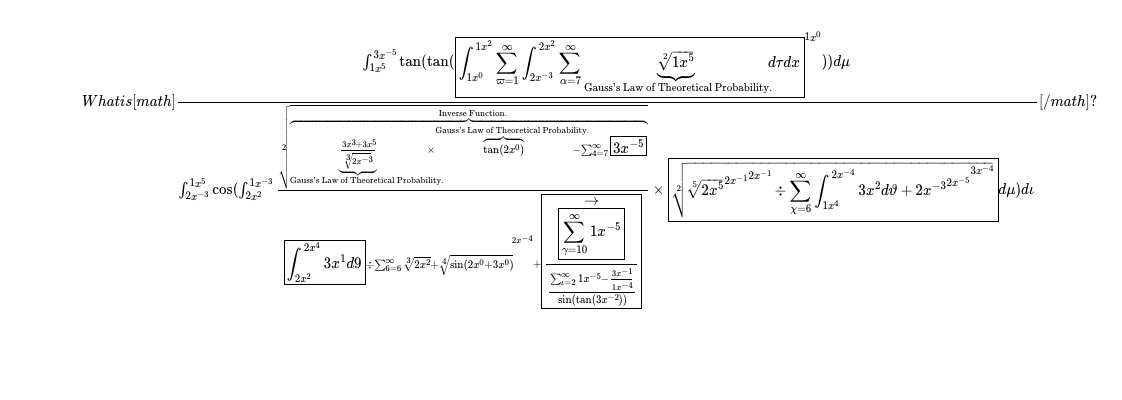
    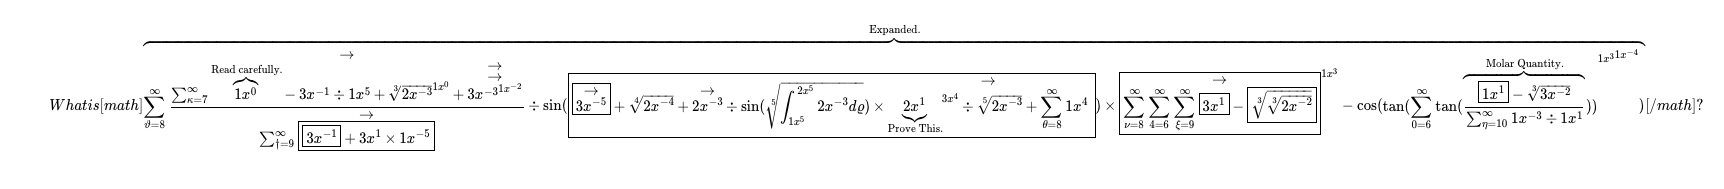
    
    * hình ảnh ở lớp sincere:
    
    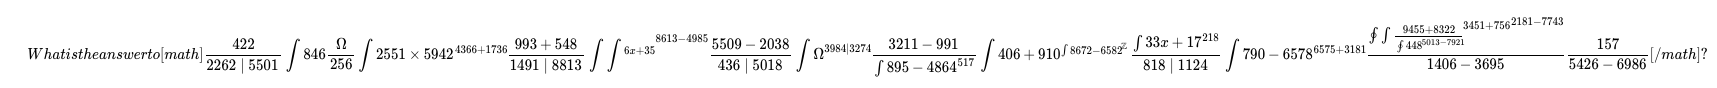
    
* Ta thấy các câu hỏi toán học được đánh dấu ở hai lớp ở trên không có vấn đề gì đáng ngờ. Tuy nhiên có khả năng vì nhiều ký tự đặc biệt nên chúng bị đánh dấu insincere
    
    
    


# 3. Tiền xử lý và clean dữ liệu 

Quá trình tiền xử lý dữ liệu gồm:
* Loại bỏ các ký tự đặc biệt có trong câu hỏi
* Xử lý các misspell words (các từ viết/phát âm không chính xác)
* Xử lý các Contractions (những từ có dấu nháy đơn ['])
* Loại bỏ số 
* Loại bỏ các tag toán học, đường dẫn

In [ ]:
# Loại bỏ các ký tự đặc biệt
def remove_special_character(text):
    text = str(text)
    for c in special_character_list: # special_character_list khi chạy boxplot ký tự đặc biệt
        if c in text:
            text = text.replace(c,'')
    return text

In [ ]:
#Xử lý các misspell 
mispell_dict = {'colour': 'color', 'centre': 'center', 'favourite': 'favorite', 'travelling': 'traveling', 'counselling': 'counseling', 'theatre': 'theater', 'cancelled': 'canceled', 'labour': 'labor', 'organisation': 'organization', 'wwii': 'world war 2', 'citicise': 'criticize', 'youtu ': 'youtube ', 'Qoura': 'Quora', 'sallary': 'salary', 'Whta': 'What', 'narcisist': 'narcissist', 'howdo': 'how do', 'whatare': 'what are', 'howcan': 'how can', 'howmuch': 'how much', 'howmany': 'how many', 'whydo': 'why do', 'doI': 'do I', 'theBest': 'the best', 'howdoes': 'how does', 'mastrubation': 'masturbation', 'mastrubate': 'masturbate', "mastrubating": 'masturbating', 'pennis': 'penis', 'Etherium': 'bitcoin', 'narcissit': 'narcissist', 'bigdata': 'big data', '2k17': '2017', '2k18': '2018', 'qouta': 'quota', 'exboyfriend': 'ex boyfriend', 'airhostess': 'air hostess', "whst": 'what', 'watsapp': 'whatsapp', 'demonitisation': 'demonetization', 'demonitization': 'demonetization', 'demonetisation': 'demonetization', 
                'electroneum':'bitcoin','nanodegree':'degree','hotstar':'star','dream11':'dream','ftre':'fire','tensorflow':'framework','unocoin':'bitcoin',
                'lnmiit':'limit','unacademy':'academy','altcoin':'bitcoin','altcoins':'bitcoin','litecoin':'bitcoin','coinbase':'bitcoin','cryptocurency':'cryptocurrency',
                'simpliv':'simple','quoras':'quora','schizoids':'psychopath','remainers':'remainder','twinflame':'soulmate','quorans':'quora','brexit':'demonetized',
                'iiest':'institute','dceu':'comics','pessat':'exam','uceed':'college','bhakts':'devotee','boruto':'anime',
                'cryptocoin':'bitcoin','blockchains':'blockchain','fiancee':'fiance','redmi':'smartphone','oneplus':'smartphone','qoura':'quora','deepmind':'framework','ryzen':'cpu','whattsapp':'whatsapp',
                'undertale':'adventure','zenfone':'smartphone','cryptocurencies':'cryptocurrencies','koinex':'bitcoin','zebpay':'bitcoin','binance':'bitcoin','whtsapp':'whatsapp',
                'reactjs':'framework','bittrex':'bitcoin','bitconnect':'bitcoin','bitfinex':'bitcoin','yourquote':'your quote','whyis':'why is','jiophone':'smartphone',
                'dogecoin':'bitcoin','onecoin':'bitcoin','poloniex':'bitcoin','7700k':'cpu','angular2':'framework','segwit2x':'bitcoin','hashflare':'bitcoin','940mx':'gpu',
                'openai':'framework','hashflare':'bitcoin','1050ti':'gpu','nearbuy':'near buy','freebitco':'bitcoin','antminer':'bitcoin','filecoin':'bitcoin','whatapp':'whatsapp',
                'empowr':'empower','1080ti':'gpu','crytocurrency':'cryptocurrency','8700k':'cpu','whatsaap':'whatsapp','g4560':'cpu','payymoney':'pay money',
                'fuckboys':'fuck boys','intenship':'internship','zcash':'bitcoin','demonatisation':'demonetization','narcicist':'narcissist','mastuburation':'masturbation',
                'trignometric':'trigonometric','cryptocurreny':'cryptocurrency','howdid':'how did','crytocurrencies':'cryptocurrencies','phycopath':'psychopath',
                'bytecoin':'bitcoin','possesiveness':'possessiveness','scollege':'college','humanties':'humanities','altacoin':'bitcoin','demonitised':'demonetized',
                'brasília':'brazilia','accolite':'accolyte','econimics':'economics','varrier':'warrier','quroa':'quora','statergy':'strategy','langague':'language',
                'splatoon':'game','7600k':'cpu','gate2018':'gate 2018','in2018':'in 2018','narcassist':'narcissist','jiocoin':'bitcoin','hnlu':'hulu','7300hq':'cpu',
                'weatern':'western','interledger':'blockchain','deplation':'deflation', 'cryptocurrencies':'cryptocurrency', 'bitcoin':'blockchain cryptocurrency',}

def correct_mispell(x):
    words = x.split()
    for i in range(0, len(words)):
        if mispell_dict.get(words[i]) is not None:
            words[i] = mispell_dict.get(words[i])
        elif mispell_dict.get(words[i].lower()) is not None:
            words[i] = mispell_dict.get(words[i].lower())
        
    words = " ".join(words)
    return words

In [ ]:
#Loại bỏ các stopwords
def remove_stopwords(text):
    text = [word for word in text.split() if word not in STOPWORDS]
    text = ' '.join(text)
    return text

In [ ]:
#Xử lý các contraction
contraction_map = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have" }
def clean_contractions(text):
    specials = ["’", "‘", "´", "`"]
    for s in specials:
        text = text.replace(s, "'")
    
    text = ' '.join([contraction_map[t] if t in contraction_map else t for t in text.split(" ")])
    return text
    

In [ ]:
# loại bỏ số
def clean_numbers(text):
    text = re.sub('[0-9]{5,}', '#####', text)
    text = re.sub('[0-9]{4}', '####', text)
    text = re.sub('[0-9]{3}', '###', text)
    text = re.sub('[0-9]{2}', '##', text)
    return text

In [ ]:
#Lemamatizing
"""
word_lemmatizer = WordNetLemmatizer()
def lemma_word(text):
    text = text.split()
    text =[word_lemmatizer.lemmatize(w) for w in text]
    return ' '.join(text)
"""

In [ ]:
# Xóa bỏ các tag toán học, đường dẫn 
def clean_tag(x):
    if '[math]' in x:
        x = re.sub('\[math\].*?math\]', 'MATH EQUATION', x) #replacing with [MATH EQUATION]
    
    if 'http' in x or 'www' in x:
        x = re.sub('(?:(?:https?|ftp):\/\/)?[\w/\-?=%.]+\.[\w/\-?=%.]+', 'URL', x) #replacing with [url]
    return x

In [ ]:
def clean_data(text):
    text = clean_tag(text)
    text = clean_contractions(text)
    text = correct_mispell(text)
    text = clean_numbers(text)
    text = remove_special_character(text)
    return text

In [ ]:
train_df['preprocessed_question_text'] = train_df['question_text'].apply(lambda x: clean_data(x))
test_df['preprocessed_question_text'] = test_df['question_text'].apply(lambda x: clean_data(x))

In [ ]:
train_df.head(20)

In [ ]:
test_df.head(20)

In [ ]:
embed_size = 300
max_features = 150000
maxlen = 70
n_epochs = 10
n_splits = 5

batch_size = 512

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

Sau khi tiền xử lý, làm sạch dữ liệu. Ta sẽ tiến hành các bước như sau

![](https://miro.medium.com/max/1218/1*zsIXWoN0_CE9PXzmY3tIjQ.png)




In [ ]:
train_X = train_df['preprocessed_question_text'].values
test_X = test_df['preprocessed_question_text'].values
tokenizer = Tokenizer(num_words = max_features)

#tokenizer từ trong tập train và tập huấn luyện
tokenizer.fit_on_texts(list(train_X)+list(test_X))

train_X = tokenizer.texts_to_sequences(train_X)
test_X = tokenizer.texts_to_sequences(test_X)

# tạo một dict để mapping từ và số thứ tự
word_index = tokenizer.word_index # type: dict

# reize lại mảng để có độ dài bằng nhau
train_X = pad_sequences(train_X,maxlen = maxlen)
test_X = pad_sequences(test_X, maxlen=maxlen)

train_Y = train_df['target'].values

Ta sẽ sử dụng bộ pre trained embedding của glove đã được cho sẵn bởi cuộc thi 

In [ ]:
!unzip ../input/quora-insincere-questions-classification/embeddings.zip

In [ ]:
def load_glove(word_index):
    EMBEDDING_FILE = './glove.840B.300d/glove.840B.300d.txt'
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')[:300]
    
    f = open(EMBEDDING_FILE,encoding="utf-8")
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in f)
    
    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = -0.005838499,0.48782197
    embed_size = all_embs.shape[1]

    # word_index = tokenizer.word_index
    nb_words = min(max_features, len(word_index))
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        #ALLmight
        if embedding_vector is not None: 
            embedding_matrix[i] = embedding_vector
        else:
            embedding_vector = embeddings_index.get(word.capitalize())
            if embedding_vector is not None: 
                embedding_matrix[i] = embedding_vector
    return embedding_matrix 

In [ ]:
glove_embedding = load_glove(tokenizer.word_index)
#fasttext_embedding = load_wiki(tokenizer.word_index)
#para_embedding = load_para(tokenizer.word_index)
#embedding_matrix = np.mean([glove_embedding, fasttext_embedding, para_embedding], axis = 0)
embedding_matrix = glove_embedding

In [ ]:
print(embedding_matrix.shape)

Ta sử dụng phương pháp K-fold, để chia tập training. Phần dữ liệu training thì sẽ được chia thành K phần (K ở đây ta cho bằng 5). Sau đó train model K lần, mỗi lần train sẽ chọn 1 phần làm dữ liệu validation và K-1 phần con lại làm training set. Kết quả cuối cùng sẽ là trung bình cộng kết quả đánh giá của K lần train


![](https://web888.vn/wp-content/uploads/2021/09/image-108.png)


In [ ]:
splits = list(StratifiedKFold(n_splits=5, shuffle=True, random_state=2000).split(train_X, train_Y))

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') 
print(device)

# 4. Mô hình sử dụng
## 4.1 Mô hình hồi quy Logistic
* Đã được giảng viên dạy: https://excessive-source-1c9.notion.site/16-09-2021-H-i-quy-Logistics-cdcc911147e5458ba9203b58e6bd0099
* Notebook cho xử lý bài toán bằng mô hình hồi quy logistic: https://www.kaggle.com/dinhvietahn19021217/toxic-quora-question/notebook
* Điểm số đạt được: private score: 0.36198, public score: 0.36785


## 4.2 Mô hình Bidirectional LSTM
#### RNN (Recuurent Neural Networks)
* RNN là một mạng neural networks cho phép các đầu ra trước đó được sử dụng làm đầu vào khi có các trạng thái ẩn. 
* Trong lý thuyết ngôn ngữ, ngữ nghĩa của câu được tạo thành từ một chuỗi các từ trong câu theo một cấu trúc ngữ pháp. Do đó cần phải có một kiến trúc mạng đặc biệt cho neural netwwork biểu diễn chuỗi từ này nhằm mục đích liên kết các từ liền trước với các từ hiện tại để tạo ra mối liên hệ xâu chuỗi. RNN đã được thiết kế để giải quyết yêu cầu này

##### Mô hình
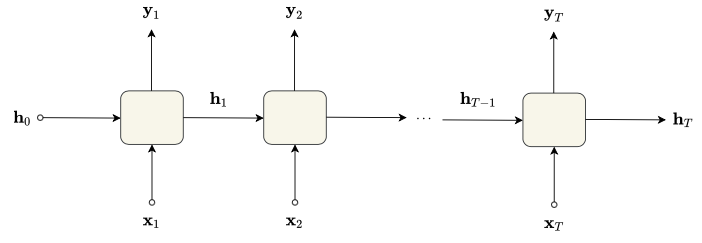

* Mô hình gồm t input, các input được đưa vào mô hình đúng với thứ tự từ trong câu
* Mỗi hình vuông được gọi là 1 state, đầu vào mỗi state là $ x_t $, $h_{t-1}$ với $h_t = f(W*x_t + U*h_{t-1})$. (W là trọng số của đầu vào, U là trọng số của trạng thái ẩn), $f$ là activation value như: sigmoid, tanh, ReLU,....
* Có thể thấy $h_t$ mang cả thông tin từ hidden state trước 
* $h_0$ được thêm vào để cho chuẩn công thức nên thường được gán bằng 0 hoặc giá trị ngẫu nhiên
* $y_t = g(V*h_t)$. V là trọng số của trạng thái ẩn sau khi tính đầu ra

#### LSTM (Long short term memory)
* Điểm yếu của RNN là không học được các thông tin trước đó ở xa do bị vanishing graident. Mạng LSTM ra đời để khắc phục điểm yếu này 

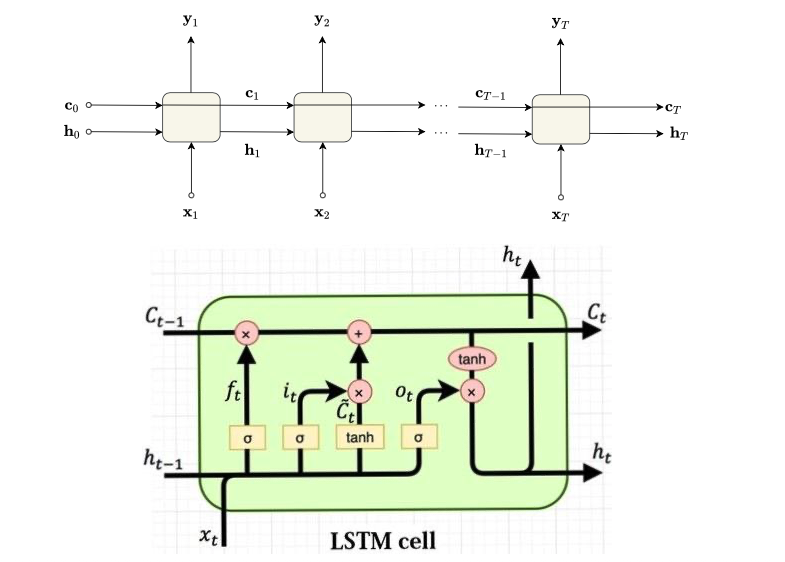

* Ở state thứ t của mô hình
    * output: $c_t$  là cell state, $h_t$ là hidden state     
    * input: $c_{t-1},h_{t-1}$. Ở đây $c$ là điểm mới so với RNN
* Tính toán trong ô LSTM:
    * Cổng quên (forget gate): $\mathbf f_t = \sigma(\mathbf W_{f} \mathbf x_t + \mathbf U_{f}\mathbf h_{t-1})$
    * Cổng đầu vào (input gate): $\mathbf i_t = \sigma(\mathbf W_{i} \mathbf x_t + \mathbf U_{i}\mathbf h_{t-1})$
    * Cổng đầu ra (output gate): $\mathbf o_t = \sigma(\mathbf W_{o} \mathbf x_t + \mathbf U_{o}\mathbf h_{t-1})$
    * $\tilde{\mathbf c}_t = \mathrm{tanh}(\mathbf W_{c} \mathbf x_t + \mathbf U_{c}\mathbf h_{t-1})$
    * Cổng trạng thái ô (cell state): $\mathbf c_{t} = \mathbf f_t \times \mathbf c_{t-1} + \mathbf i_t \times \tilde{\mathbf c}_t$. Forget gate quyết định xem lấy bao nhiêu từ cell state trước và input gate sẽ quyết định lấy bao nhiêu từ input của state và hidden state của state trước
    * $ \mathbf h_t = \mathrm{tanh}(c_t) \times \mathbf o_t $ , $\mathbf y_t = \phi_y(\mathbf W_y \mathbf h_t)$
* Ta thấy LSTM là RNN được hiệu chỉnh bởi $c_t$, thông tin nào cần quan trọng và dùng ở sau sẽ được gửi vào và dùng khi cần => có thể mang thông tin đi xa

#### Bidirectional LSTM 

![](https://production-media.paperswithcode.com/methods/Screen_Shot_2020-05-25_at_8.54.27_PM.png)

* Bidirectional LSTM là mô hình gồm hai LSTM: LSTM thứ nhất nhận đầu vào là chuỗi các từ theo thứ tự từ trái sang phải, LSTM còn lại nhận đầu vào là chuỗi các từ theo thứ tự từ phải sang trái. Điều này làm tăng hiệu quả lượng thông tin có sẵn, đồng thời cải thiện ngữ cảnh có sẵn cho thuật toán.


#### Kiến trúc mô hình sử dụng
* Lớp Embedding layer sử dụng embbeding của glove
* BiLSTM
* 2 lớp linear, với hàm kích hoạt relu
* dropout 



In [ ]:
class LSTM_Model(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.embedding = nn.Embedding(150000, 300)
        self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
        self.embedding.weight.requires_grad = False
        self.lstm = nn.LSTM(300, 64, bidirectional=True, batch_first=True)
        self.fc1 = nn.Linear(64*2 , 64)
        self.fc2 = nn.Linear(64,1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.1)
    
    def forward(self, x):
        out = self.embedding(x)
        out, (h,c) = self.lstm(out)
        cat = torch.cat((h[-2,:,:],h[-1,:,:]),dim=1) # đầu ra của hai hướng LSTM sẽ được kết hợp ở trạng thái cuối 
        out = self.relu(cat)
        out = self.dropout(self.fc1(out))
        out = self.fc2(out)
        return out


In [ ]:
# Ở phần thực hiện training em tham khảo đoạn code: https://www.kaggle.com/oysiyl/107-place-solution-using-public-kernel

Thuật toán huấn luyện:
* Lấy một fold trong tập fold đã được chia:
    * Lặp epoch = 1,2,...
        * mô hình thực hiện forward
        * Tính đạo hàm và cập nhật trọng số của mô hình
        

In [ ]:
train_epochs = 6
x_test = torch.tensor(test_X, dtype=torch.long).to(device)
test = torch.utils.data.TensorDataset(x_test)
test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False)



train_preds= np.zeros((len(train_X)))
test_preds = np.zeros((len(test_X)))
for i_fold, (train_idx, valid_idx) in enumerate(splits):

    x_train_fold = torch.tensor(train_X[train_idx], dtype=torch.long).to(device)
    y_train_fold = torch.tensor(train_Y[train_idx, np.newaxis], dtype=torch.float32).to(device)
    x_val_fold = torch.tensor(train_X[valid_idx], dtype=torch.long).to(device)
    y_val_fold = torch.tensor(train_Y[valid_idx, np.newaxis], dtype=torch.float32).to(device)
    
    train = torch.utils.data.TensorDataset(x_train_fold, y_train_fold)
    valid = torch.utils.data.TensorDataset(x_val_fold, y_val_fold)
    
    #Load data 
    train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)
    
    # mô hình 
    model = LSTM_Model().to(device)
    # hàm loss và adam optimizer
    criterion = torch.nn.BCEWithLogitsLoss(reduction='sum')
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    print(f'Fold {i_fold + 1}')
    
    avg_losses_f = []
    avg_val_losses_f = []

    for epoch in range(train_epochs):
        model.train()
        avg_loss = 0.
        for batch_i,(x_batch, y_batch) in enumerate(train_loader):
            # lan truyền tới 
            y_pred = model(x_batch)
            # tính hàm mất mát
            loss = criterion(y_pred, y_batch)

            optimizer.zero_grad()
            # lan truyền ngược 
            loss.backward()
            # cập nhật lại trọng số mô hình
            optimizer.step()
            
            avg_loss += loss.item() / len(train_loader)
            
        # Kiểm tra mô hình với tập validation 
        model.eval()
        valid_preds_fold = np.zeros(x_val_fold.size(0))
        test_preds_fold = np.zeros(len(test_X))
        
        avg_val_loss = 0.
        for batch_i, (x_batch, y_batch) in enumerate(valid_loader):
            y_pred = model(x_batch).detach()
            avg_val_loss += criterion(y_pred, y_batch).item() / len(valid_loader)
            valid_preds_fold[batch_i * batch_size:(batch_i+1) * batch_size] = torch.sigmoid(y_pred.cpu())[:, 0]

        print('Epoch {}/{} \t loss={:.2f} \t val_loss={:.2f}'.format(epoch + 1, train_epochs, avg_loss, avg_val_loss))
        avg_losses_f.append(avg_loss)
        avg_val_losses_f.append(avg_val_loss)
    # Biểu đồ sau mỗi fold
    plt.figure(figsize=(10,5))
    plt.title(f'Loss During Training in Fold {i_fold + 1}')
    plt.plot(avg_losses_f,label="training")
    plt.plot(avg_val_losses_f,label="valid")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    # Dự đoán tập test sau mỗi fold 
    for batch_i, (x_batch,) in enumerate(test_loader):
        y_pred = model(x_batch).detach()
        test_preds_fold[batch_i * batch_size:(batch_i+1) * batch_size] = torch.sigmoid(y_pred.cpu())[:, 0]

    train_preds[valid_idx] = valid_preds_fold
    test_preds += test_preds_fold / len(splits)


In [ ]:
from sklearn.metrics import f1_score
def bestThresshold(y_train,train_preds_):
    thres = 0.0
    max_f1 = 0.0 
    for t in np.arange(0.1, 0.5, 0.01):
        t = np.round(t,2)
        f1_score_ = f1_score(y_train,np.array(train_preds_)>t)
        if f1_score_ > max_f1:
            thres = t
            max_f1 = f1_score_
    print(thres,max_f1)
    return thres 

bestThres = bestThresshold(train_Y,train_preds)

In [ ]:
submission = test_df[['qid']].copy()
submission['prediction'] = (test_preds > bestThres).astype(int)
submission.to_csv('submission.csv', index=False)

# 5. Kết luận
* Mô hình BiLSTM cho ra số điểm tốt hơn nhiều so với mô hình hồi quy logistc
* Có thể kết hợp nhiều pre trained embedding để cải thiện chất lượng trong quá trình preprocessing